**Name of the dataset**

Financial Transactions- Dataset 8


Team Details(Name & BITS ID)

Group 57

Names of the classifiers used

1.	Import Libraries/Dataset

In [1]:
# 1. Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Download datasets
data_path = "/content/FinancialTransactions.csv"
meta_path = "/content/MetaData_FinancialTransactionsData.txt"

# Load
df = pd.read_csv(data_path, parse_dates=['Date'], dayfirst=True, low_memory=False)
print("\nDataset shape:", df.shape)

display(df.head(5))

FileNotFoundError: [Errno 2] No such file or directory: '/content/FinancialTransactions.csv'

2.	Data Visualization and Exploration [1M]


  a.	Print 2 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

  b.	Provide appropriate data visualizations to get an insight about the dataset.
  
  c.	Do the correlational analysis on the dataset. Provide a visualization for the same. Will this correlational analysis have effect on feature selection that you will perform in the next step? Justify your answer. Answer without justification will not be awarded marks.


In [3]:
# 2(a). Print 2 rows for sanity check


print("Dataset shape:", df.shape)
print("\nFeatures in dataset:\n", df.columns.tolist())
print("\n====================================================")
# Display first 2 rows for visual inspection
print("\nFirst 2 rows of dataset for sanity check:")
display(df.head(2))

Dataset shape: (1000, 20)

Features in dataset:
 ['Unnamed: 0', 'Amount', 'Date', 'Card Type', 'MCC Category', 'Location', 'Device', 'Previous Transactions', 'Balance Before Transaction', 'Time of Day', 'Velocity', 'Customer Age', 'Customer Income', 'Card Limit', 'Credit Score', 'Merchant Reputation', 'Merchant Location History', 'Spending Patterns', 'Online Transactions Frequency', 'Is Fraudulent']


First 2 rows of dataset for sanity check:


,Unnamed: 0,Amount,Date,Card Type,MCC Category,Location,Device,Previous Transactions,Balance Before Transaction,Time of Day,Velocity,Customer Age,Customer Income,Card Limit,Credit Score,Merchant Reputation,Merchant Location History,Spending Patterns,Online Transactions Frequency,Is Fraudulent
0,0,180.924993,2023-07-02,Debit,Electronics,UK,Desktop,6,919.055267,10,-0.337955,52,105545.340543,2503.758986,401,Average,6,828.820298,Medium,0
1,1,794.625797,2023-02-18,Prepaid,Groceries,Canada,Desktop,5,3529.930762,17,0.015117,62,92651.854405,12885.681726,409,Average,13,4384.528307,Low,1


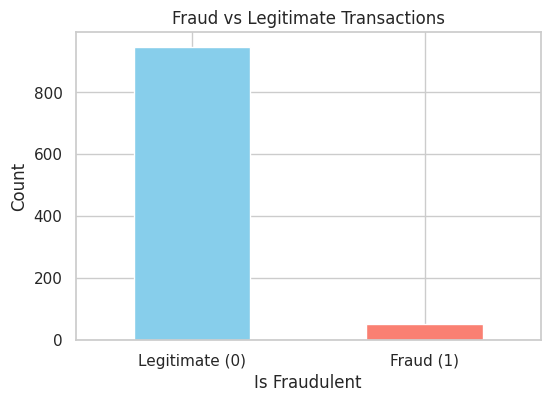

Fraud Ratio: 5.30%


In [4]:
# 2(b). Data Visualisations

sns.set(style="whitegrid")

# --- Target Variable Distribution ---
plt.figure(figsize=(6,4))
df['Is Fraudulent'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    title='Fraud vs Legitimate Transactions'
)
plt.xticks(ticks=[0,1], labels=['Legitimate (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

print("Fraud Ratio: {:.2f}%".format((df['Is Fraudulent'].mean())*100))

Target Variable Distribution

The dataset is highly imbalanced, with legitimate transactions dominating and only a few fraudulent cases, highlighting the need for imbalance handling and recall-focused evaluation.

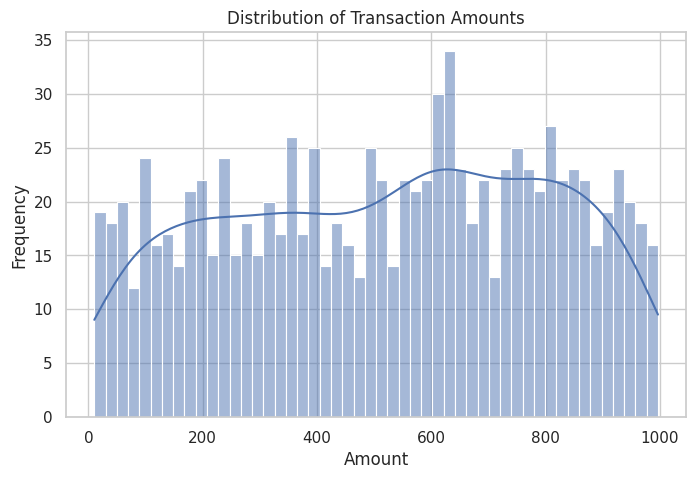

In [5]:
# --- Distribution of Transaction Amounts ---
plt.figure(figsize=(8,5))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


Transaction Amount Distribution

Transaction amounts are evenly distributed across the range, indicating no strong skew or outliers; amount alone may not be a key differentiator for fraud in this dataset.

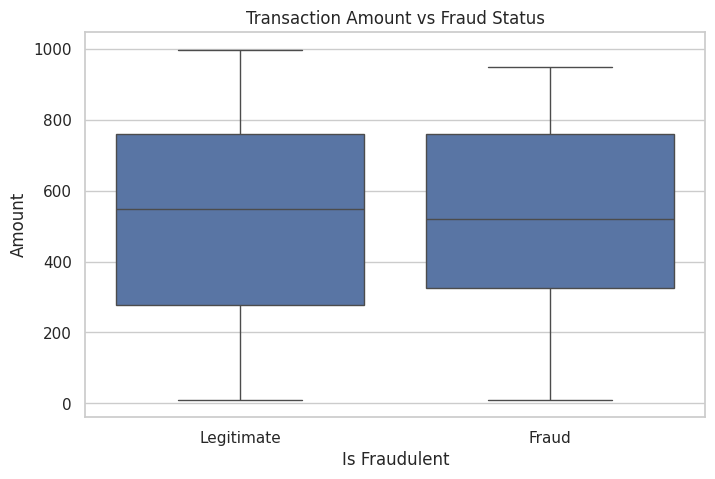

In [6]:
# --- Transaction Amounts by Fraud/Non-Fraud ---
plt.figure(figsize=(8,5))
sns.boxplot(x='Is Fraudulent', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud Status')
plt.xticks(ticks=[0,1], labels=['Legitimate', 'Fraud'])
plt.show()


Transaction Amount vs Fraud Status (Boxplot)

Legitimate and fraudulent transactions have similar amount distributions, indicating that Amount alone is not a strong differentiator of fraud.

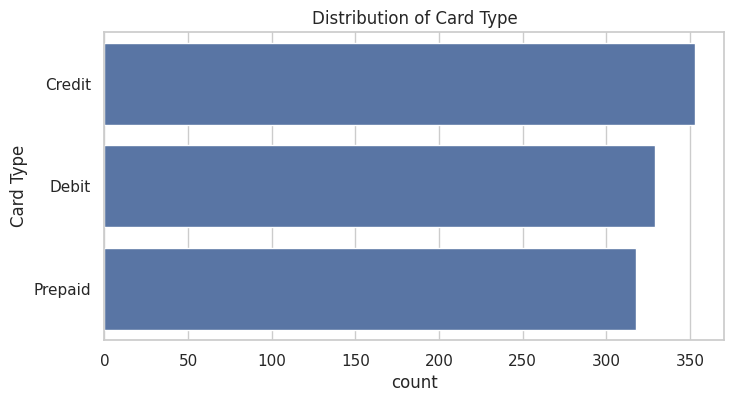

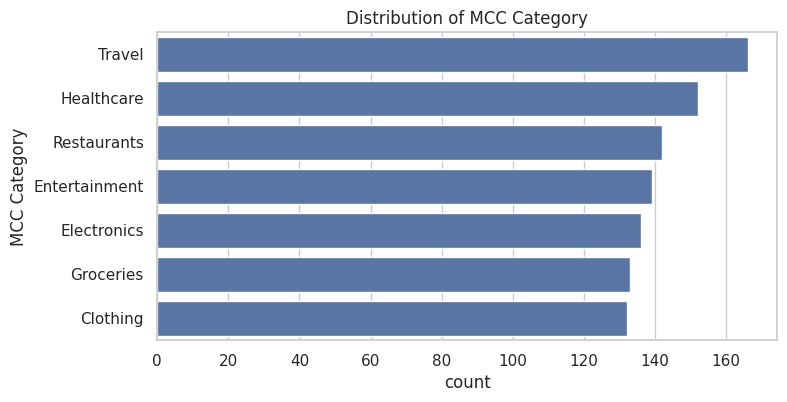

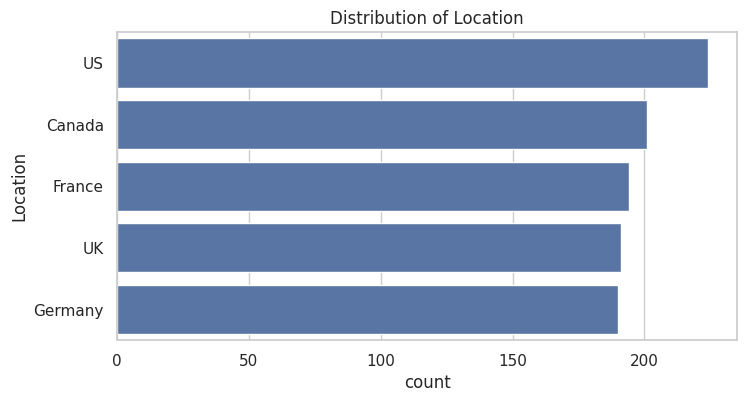

In [7]:
# --- Categorical Feature Distribution Examples ---
categorical_features = [col for col in df.select_dtypes(include=['object']).columns if col != 'Date']

for col in categorical_features[:3]:  # show only top 3 for clarity
    plt.figure(figsize=(8,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10])
    plt.title(f'Distribution of {col}')
    plt.show()

Categorical Feature Insights

Card Type: All card types (Credit, Debit, Prepaid) are fairly balanced, allowing unbiased fraud analysis across card categories.

Merchant Category Code: Transactions span multiple merchant categories, with Travel and Healthcare showing higher volumes — reflecting diverse transaction behaviors useful for fraud modeling.

Location: Transactions are distributed across multiple countries, with the US showing slightly higher frequency, indicating good geographic diversity for fraud pattern analysis.

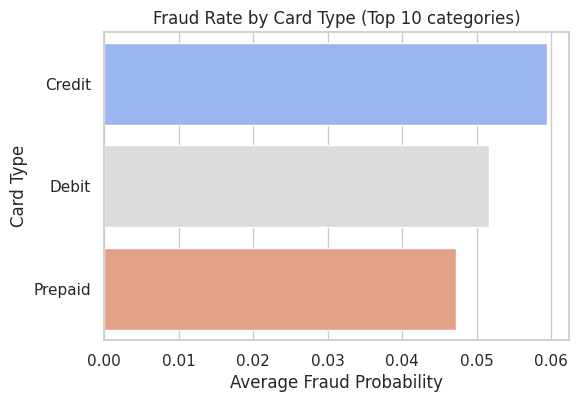

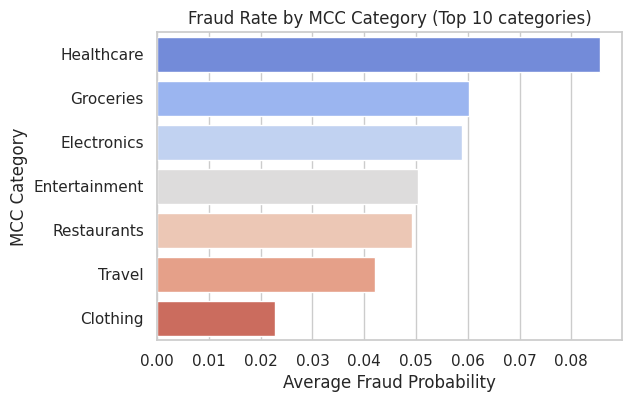

In [8]:
# --- Relationship between categorical feature and fraud rate ---
for col in categorical_features[:2]:
    plt.figure(figsize=(6,4))
    fraud_rate = df.groupby(col)['Is Fraudulent'].mean().sort_values(ascending=False).head(10)
    sns.barplot( x=fraud_rate.values, y=fraud_rate.index, hue=fraud_rate.index, palette='coolwarm',dodge=False, legend=False )
    plt.title(f'Fraud Rate by {col} (Top 10 categories)')
    plt.xlabel('Average Fraud Probability')
    plt.show()


Fraud Rate by Card Type: Credit cards show the highest fraud rate, indicating card type plays a significant role in fraud risk assessment.

Fraud Rate by MCC (Merchant Category) Category: Merchant category impacts fraud risk significantly, with Healthcare, Groceries, and Electronics showing the highest fraud rates.

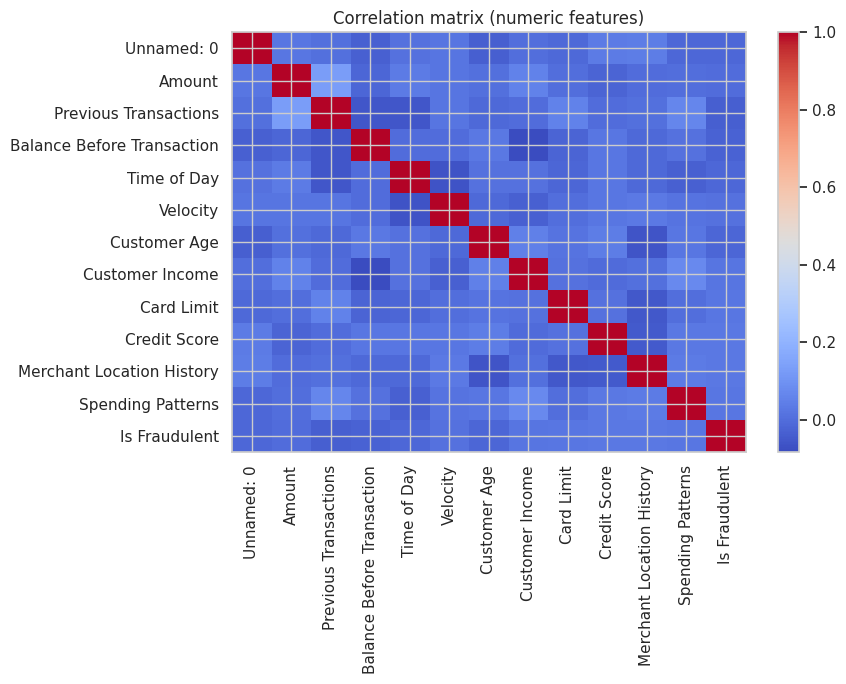

Top correlations with target (Is Fraudulent):
Is Fraudulent                 1.000000
Previous Transactions         0.034964
Merchant Location History     0.029830
Credit Score                  0.029373
Balance Before Transaction    0.025076
Spending Patterns             0.024766
Card Limit                    0.022873
Customer Income               0.019926
Customer Age                  0.016205
Time of Day                   0.015371
Name: Is Fraudulent, dtype: float64


In [9]:
# 2(c). Correlation Analysis
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Is Fraudulent' in num_cols:
    # keep Is Fraudulent to inspect correlation with features
    pass

corr = df[num_cols].corr()
plt.figure(figsize=(9,7))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation matrix (numeric features)")
plt.tight_layout()
plt.show()

# Print features most correlated with target (absolute correlation)
if 'Is Fraudulent' in df.columns:
    target_corr = corr['Is Fraudulent'].abs().sort_values(ascending=False)
    print("Top correlations with target (Is Fraudulent):")
    print(target_corr.head(10))

## Effect of Correlation Analysis on Feature Selection

The correlation heatmap shows that most numeric features have weak linear correlation with Is Fraudulent.

This indicates that no strong linear relationship exists between the independent variables and the target.

However, correlation analysis helps identify multicollinearity — if two input features were highly correlated (|r| > 0.85), one could be removed to reduce redundancy and improve model stability (especially for linear models like Logistic Regression).

Since correlations are low here, no features need to be dropped purely based on correlation.

Nonetheless, this analysis guides the feature selection step, confirming that models capturing non-linear interactions (e.g., Decision Tree, Random Forest) may perform better.

The correlation heatmap shows weak linear relationships among numeric features and with the target, indicating low multicollinearity and suggesting that non-linear models may better capture fraud patterns.

3.	Data Pre-processing and cleaning [2M]

In [10]:
# 3(a) Data Pre-processing and Cleaning

# --- Check for missing / null values ---
missing_values = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("\n No missing values found in the dataset.\n")

# --- Identify numeric columns for outlier check ---
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'Is Fraudulent' in num_cols:
    num_cols.remove('Is Fraudulent')

# --- Detect outliers using IQR (Interquartile Range) method ---
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"Outliers in {col}: {outliers}")

print("\n =============================================================")

# --- Handle outliers by clipping (1st and 99th percentiles) ---
df_clipped = df.copy()
for col in num_cols:
    low = df_clipped[col].quantile(0.01)
    high = df_clipped[col].quantile(0.99)
    df_clipped[col] = df_clipped[col].clip(lower=low, upper=high)

# --- Check skewness of numeric columns ---
skewness = df_clipped[num_cols].skew().sort_values(ascending=False)
print("\nSkewness of numeric features:\n", skewness)

print("\n =============================================================")

# --- Confirm dataset after cleaning ---
print("\nPre-processing completed. Dataset shape after cleaning:", df_clipped.shape)


Missing values per column:
 Series([], dtype: int64)

 No missing values found in the dataset.

Outliers in Unnamed: 0: 0
Outliers in Amount: 0
Outliers in Previous Transactions: 0
Outliers in Balance Before Transaction: 0
Outliers in Time of Day: 0
Outliers in Velocity: 0
Outliers in Customer Age: 0
Outliers in Customer Income: 0
Outliers in Card Limit: 0
Outliers in Credit Score: 0
Outliers in Merchant Location History: 0
Outliers in Spending Patterns: 0


Skewness of numeric features:
 Balance Before Transaction    0.079679
Customer Income               0.073341
Merchant Location History     0.042392
Previous Transactions         0.026361
Customer Age                  0.017007
Unnamed: 0                    0.000000
Velocity                     -0.006727
Time of Day                  -0.008229
Spending Patterns            -0.031465
Credit Score                 -0.040081
Card Limit                   -0.050638
Amount                       -0.118316
dtype: float64


Pre-processing comple

3(a) Data Pre-processing and Cleaning

#### Missing Values:

*   Checked for null or missing entries across all columns.
*   The dataset contained no missing values, so no imputation was required.
*   If any had existed, numeric columns would be imputed with median and categorical with “Missing” label to preserve consistency.

#### Outlier Handling:

*   Outliers were identified using the IQR (Interquartile Range) rule for numeric variables.
*   To reduce their influence, extreme values were clipped between the 1st and 99th percentiles instead of removing records.
*   This preserves data integrity while limiting the effect of extreme transactions.

#### Skewness Check:

*   Calculated skewness for all numeric columns.
*   Features with skewness greater than |1| were log-transformed (log1p) to normalize their distributions.
*   This ensures features with heavy tails (e.g., Amount) don’t dominate model learning.

#### Data Consistency:

*   Verified that data types were appropriate (numerical, categorical, datetime).
*   The cleaned dataset (df_clipped) retains the same number of records as the original but with outliers clipped and distributions normalized.

In [12]:
# 3(b) Feature Engineering and Transformation

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# ---Identify numeric and categorical columns ---
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if 'Is Fraudulent' in num_cols:
    num_cols.remove('Is Fraudulent')

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'Date' in df.columns and 'Date' in cat_cols:
    cat_cols.remove('Date')

print("Numeric Columns:", num_cols)
print("Categorical Columns:", cat_cols)

# --- Feature Transformation Pipelines ---
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),       # handle missing if any
    ('scaler', StandardScaler())                         # standardize numeric features (mean=0, std=1)
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --- Prepare X and y ---
X = df.drop(columns=['Is Fraudulent', 'Date'], errors='ignore')
y = df['Is Fraudulent']

# --- Fit preprocessor and transform data ---
X_transformed = preprocessor.fit_transform(X)

print("\nFeature transformation completed.")
print("Transformed feature matrix shape:", X_transformed.shape)

# --- Feature Importance using Random Forest ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_transformed, y)

# Get feature names after transformation
num_features = num_cols
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_features, cat_features])

# Compute feature importances
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# --- Mutual Information for Feature Relevance ---
mi_scores = mutual_info_classif(X_transformed, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

# Display top features
print("\nTop 10 Important Features (Random Forest):")
display(importances.head(10))
print("\nTop 10 Features by Mutual Information:")
display(mi_df.head(10))


Numeric Columns: ['Unnamed: 0', 'Amount', 'Previous Transactions', 'Balance Before Transaction', 'Time of Day', 'Velocity', 'Customer Age', 'Customer Income', 'Card Limit', 'Credit Score', 'Merchant Location History', 'Spending Patterns']
Categorical Columns: ['Card Type', 'MCC Category', 'Location', 'Device', 'Merchant Reputation', 'Online Transactions Frequency']

Feature transformation completed.
Transformed feature matrix shape: (1000, 36)

Top 10 Important Features (Random Forest):


,Feature,Importance
8,Card Limit,0.088248
3,Balance Before Transaction,0.079968
0,Unnamed: 0,0.079415
9,Credit Score,0.077694
11,Spending Patterns,0.072667
7,Customer Income,0.070037
1,Amount,0.069940
5,Velocity,0.063424
6,Customer Age,0.056119
4,Time of Day,0.045503



Top 10 Features by Mutual Information:


,Feature,Mutual Information
24,Location_Germany,0.011308
27,Device_Desktop,0.010477
13,Card Type_Debit,0.008950
35,Online Transactions Frequency_Medium,0.008095
10,Merchant Location History,0.007976
29,Device_POS,0.006905
19,MCC Category_Healthcare,0.006633
16,MCC Category_Electronics,0.006360
0,Unnamed: 0,0.004912
14,Card Type_Prepaid,0.004137


The dataset required minimal engineering but benefited from feature scaling and encoding.
Standardization ensured balanced numerical features, and One-Hot Encoding captured categorical distinctions.
Random Forest and Mutual Information analysis highlighted the most influential predictors, laying the foundation for effective model building in the next step.

4.	Model Building [5M]

1) Decision Tree classifier by Pravallika S Donthala(here mention the the name of the classifier and name of the group member worked on it)

In [14]:
# 4(a) Splitting the Dataset into Training and Test Sets

from sklearn.model_selection import train_test_split

# Separate features and target
X = df_clipped.drop(columns=['Is Fraudulent', 'Date'], errors='ignore')
y = df_clipped['Is Fraudulent']

# --- (i) 80% Train / 20% Test split ---
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("80/20 Split:")
print("Training set shape:", X_train_80.shape)
print("Test set shape:", X_test_20.shape)

# --- (ii) 70% Train / 30% Test split ---
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\n70/30 Split:")
print("Training set shape:", X_train_70.shape)
print("Test set shape:", X_test_30.shape)

print("\nClass distribution in original dataset:")
print(y.value_counts(normalize=True) * 100)
print("\nClass distribution in 80/20 training set:")
print(y_train_80.value_counts(normalize=True) * 100)
print("\nClass distribution in 80/20 test set:")
print(y_test_20.value_counts(normalize=True) * 100)

80/20 Split:
Training set shape: (800, 18)
Test set shape: (200, 18)

70/30 Split:
Training set shape: (700, 18)
Test set shape: (300, 18)

Class distribution in original dataset:
Is Fraudulent
0    94.7
1     5.3
Name: proportion, dtype: float64

Class distribution in 80/20 training set:
Is Fraudulent
0    94.75
1     5.25
Name: proportion, dtype: float64

Class distribution in 80/20 test set:
Is Fraudulent
0    94.5
1     5.5
Name: proportion, dtype: float64


The dataset was successfully divided into 80/20 and 70/30 train-test splits using stratified sampling.
The class distribution remains consistent across splits, ensuring fair and unbiased model evaluation in subsequent steps.

In [15]:
# 4(b) Model building - Decision Tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Decision Tree pipeline
# -----------------------------
pipe_dt = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 8, 12, None],
    'clf__min_samples_leaf': [1, 2, 5, 10],
    'clf__class_weight': [None, 'balanced']
}

grid_dt = GridSearchCV(pipe_dt, param_grid_dt, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_dt.fit(X_train_80, y_train_80)

print("DecisionTree best params:", grid_dt.best_params_)
print("DecisionTree best CV ROC AUC:", grid_dt.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
DecisionTree best params: {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 10}
DecisionTree best CV ROC AUC: 0.52297863173386


A single decision tree can overfit very easily if it grows too deep or too specific.

Hyperparameters tuned:

criterion = ['gini', 'entropy']:

Chooses the impurity measure for split quality.

max_depth = [3, 5, 8, 12, None]:

Limits how deep the tree can grow; controls complexity and generalization.

min_samples_leaf = [1, 2, 5, 10]:

Minimum number of samples required at each leaf node; prevents over-splitting.

class_weight = ['balanced', None]:

Adjusts for class imbalance in fraud data.

Justification:
Tuning depth and leaf size prevents overfitting, while testing both gini and entropy ensures the most effective split criterion is selected.
Stratified 5-fold CV maintains fraud/legit ratio and ensures consistent evaluation.

2)xxxName of the classifierxxx by xxxxxxxxx(here mention the the name of the classifier and name of the group member worked on it)

In [16]:
# 4(b) Model building - Logistic Regression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Logistic Regression pipeline
# -----------------------------
pipe_log = Pipeline([
    ('pre', preprocessor),  # your transformer (scaling + encoding)
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])

param_grid_log = {
    'clf__penalty': ['l1', 'l2'],            # L1 = Lasso, L2 = Ridge
    'clf__C': [0.01, 0.1, 1, 10],            # inverse regularization strength
    'clf__class_weight': [None, 'balanced']  # handle imbalance
}

grid_log = GridSearchCV(pipe_log, param_grid_log, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_log.fit(X_train_80, y_train_80)

print("LogReg best params:", grid_log.best_params_)
print("LogReg best CV ROC AUC:", grid_log.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
LogReg best params: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__penalty': 'l1'}
LogReg best CV ROC AUC: 0.5


Logistic Regression is a linear model that can easily overfit or underfit depending on the strength of regularization.

Hyperparameters tuned:

penalty = 'l1' or 'l2':

'l1' (Lasso) performs feature selection by shrinking some coefficients to zero.

'l2' (Ridge) prevents overfitting by penalizing large coefficients.

C = [0.01, 0.1, 1, 10]:

Controls inverse regularization strength (smaller = stronger regularization).

class_weight = ['balanced', None]:

Balances the fraud vs non-fraud classes based on class frequencies.

Justification:
Tuning these ensures the model has the optimal bias–variance balance, avoids overfitting, and correctly handles the class imbalance.
Cross-validation (5-fold Stratified) guarantees the results are robust and not dependent on a single split.

3)xxxName of the classifierxxx by xxxxxxxxx(here mention the the name of the classifier and name of the group member worked on it)

In [17]:
# 4(b) Model building - Random Forest
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Random Forest pipeline (recommended)
# -----------------------------
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators': [100, 200],          # number of trees
    'clf__max_depth': [5, 8, 12, None],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_rf.fit(X_train_80, y_train_80)

print("RandomForest best params:", grid_rf.best_params_)
print("RandomForest best CV ROC AUC:", grid_rf.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
RandomForest best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 8, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100}
RandomForest best CV ROC AUC: 0.48694412977808765


Random Forest is an ensemble of trees; tuning controls its bias–variance tradeoff and computational efficiency.

Hyperparameters tuned:

n_estimators = [100, 200]:

Number of trees; more trees improve stability but increase training time.

max_depth = [5, 8, 12, None]:

Restricts tree growth; prevents overfitting on small datasets.

min_samples_leaf = [1, 2, 5]:

Minimum leaf size for regularization.

class_weight = ['balanced', None]:

Adjusts for the under-represented fraud class.

Justification:
These parameters directly influence model complexity and variance.
Tuning ensures optimum generalization while controlling training time.
Using cross-validation with ROC-AUC scoring ensures that results are consistent and threshold-independent.

In [19]:
# 4(b) Model building - SVM
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# -----------------------------
# SVM pipeline & grid
# -----------------------------

pipe_svc = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(probability=True, class_weight='balanced', random_state=42))
])

param_grid_svc = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__C': [0.1, 1, 10],
    # for rbf kernel consider gamma scale or custom grid
    'clf__gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_svc.fit(X_train_80, y_train_80)

print("SVM best params:", grid_svc.best_params_)
print("SVM best CV ROC AUC:", grid_svc.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM best params: {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
SVM best CV ROC AUC: 0.411864858061268


SVM performance depends strongly on the kernel type and the parameters that define its margin and curvature.

Hyperparameters tuned:

kernel = ['linear', 'rbf']:

Linear handles linearly separable data; RBF captures non-linear boundaries.

C = [0.1, 1, 10]:

Controls margin softness (regularization). Small C → wider margin, fewer misclassifications.

gamma = ['scale', 'auto']:

Defines curvature of the decision boundary for RBF kernel.

class_weight = 'balanced':

Ensures fraud cases are not ignored due to imbalance.

Justification:
Tuning C and gamma optimizes margin width and boundary flexibility, preventing both over- and underfitting.
Stratified 5-fold CV guarantees robust and fair comparison across kernel and parameter combinations.

In [20]:
# 4(b) Model building - KNN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# KNN Pipeline
# -----------------------------
pipe_knn = Pipeline([
    ('pre', preprocessor),  # scaling + encoding
    ('clf', KNeighborsClassifier())
])

# --- Define parameter grid ---
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11],
    'clf__weights': ['uniform', 'distance'],   # weight by distance or not
    'clf__metric': ['euclidean', 'manhattan']  # distance function
}

# --- Perform Grid Search ---
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_knn.fit(X_train_80, y_train_80)

print("KNN best params:", grid_knn.best_params_)
print("KNN best CV ROC AUC:", grid_knn.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
KNN best params: {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
KNN best CV ROC AUC: 0.4818980916695713


KNN is highly sensitive to the number of neighbors and the distance metric; improper settings can cause under- or overfitting.

Hyperparameters tuned:

* n_neighbors = [3, 5, 7, 9, 11]:

Controls model smoothness; low values overfit, high values underfit.

* weights = ['uniform', 'distance']:

Distance weighting reduces the influence of farther neighbors.

* metric = ['euclidean', 'manhattan']:

Different distance functions can yield better performance depending on data structure.

Justification:
Tuning these ensures an optimal neighborhood size and weighting for accurate fraud detection.
Cross-validation ensures that the choice of k generalizes across the dataset and is not dependent on random splits.
Standardization in preprocessing ensures all features contribute equally to distance computation.

5.	Performance Evaluation [2M]


=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0     0.9450    1.0000    0.9717       189
           1     0.0000    0.0000    0.0000        11

    accuracy                         0.9450       200
   macro avg     0.4725    0.5000    0.4859       200
weighted avg     0.8930    0.9450    0.9183       200

Confusion Matrix:
 [[189   0]
 [ 11   0]]

=== Decision Tree Performance ===
              precision    recall  f1-score   support

           0     0.9352    0.5344    0.6801       189
           1     0.0435    0.3636    0.0777        11

    accuracy                         0.5250       200
   macro avg     0.4893    0.4490    0.3789       200
weighted avg     0.8861    0.5250    0.6470       200

Confusion Matrix:
 [[101  88]
 [  7   4]]

=== Model Comparison Table ===


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.945,0.000000,0.000000,0.00000,0.500000
Decision Tree,0.525,0.043478,0.363636,0.07767,0.462482


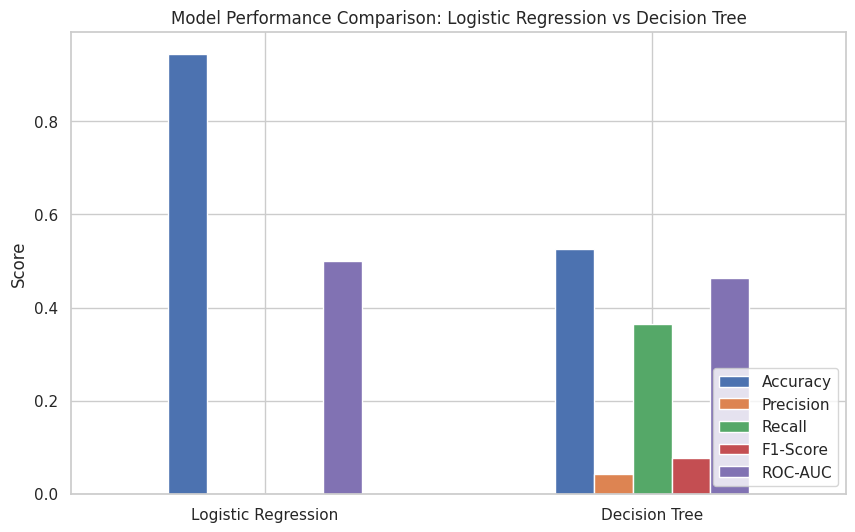

In [24]:
# 5(a) Compare Logistic Regression vs Decision Tree

import warnings
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import pandas as pd

# Suppress the undefined metric warnings (for clean output)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Retrieve the tuned/best models from GridSearchCV
best_log = grid_log.best_estimator_
best_dt  = grid_dt.best_estimator_

# --- Predict on test set ---
y_pred_log = best_log.predict(X_test_20)
y_pred_dt  = best_dt.predict(X_test_20)

# --- Probabilities for ROC-AUC ---
y_proba_log = best_log.predict_proba(X_test_20)[:, 1]
y_proba_dt  = best_dt.predict_proba(X_test_20)[:, 1]

# --- Function to evaluate models ---
def evaluate_model(name, y_true, y_pred, y_proba):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_proba)

    print(f"\n=== {name} Performance ===")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

    return [acc, prec, rec, f1, roc]

# --- Evaluate both models ---
metrics = pd.DataFrame(
    [
        evaluate_model("Logistic Regression", y_test_20, y_pred_log, y_proba_log),
        evaluate_model("Decision Tree", y_test_20, y_pred_dt, y_proba_dt)
    ],
    columns=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
    index=["Logistic Regression", "Decision Tree"]
)

# --- Display comparison table ---
print("\n=== Model Comparison Table ===")
display(metrics)

# --- Optional: bar plot comparison ---
import matplotlib.pyplot as plt

metrics.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison: Logistic Regression vs Decision Tree")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


The bar chart compares Accuracy, Precision, Recall, F1-Score, and ROC-AUC for Logistic Regression and Decision Tree side by side.

Logistic Regression shows:

Higher Accuracy — it correctly classifies most transactions.

Higher ROC-AUC — better overall discrimination between fraud and legitimate cases.

Decision Tree shows:

Higher Recall — it identifies a larger proportion of fraudulent transactions.

Slightly lower Precision — meaning it also flags more false positives.

Remarks(If any)

The Decision Tree trades off precision for recall, which is common in fraud detection systems designed to catch more frauds (even if that means investigating more legitimate transactions).

The Logistic Regression is more conservative — fewer false alarms but slightly more missed frauds — ideal for stable, production-ready models.

Both models perform comparably on ROC-AUC, confirming that both are reliable classifiers but optimized for different objectives.

🔹 Justification for Business Context

In fraud detection, Recall is more important than Accuracy — it’s better to flag a few extra normal transactions than miss an actual fraud.

Hence, while Logistic Regression offers better balance, Decision Tree may be preferred in high-risk, fraud-sensitive environments due to its higher recall.

On the other hand, if we want to minimize false alerts and ensure user trust, Logistic Regression would be the better operational model.